In [255]:
import random
import numpy as np


class Function:
    def __init__(self, value, delt=0.001):
        self.value = value

        def grad(x):
            array = []
            for i in range(len(x)):
                x[i] += delt
                first_val = value(x)
                x[i] -= 2 * delt
                second_val = value(x)
                x[i] += delt
                array.append((first_val - second_val) / (2 * delt))
            return np.array(array)

        self.grad = grad


wolfe_cond_template = lambda c1, c2, x, func, gk: lambda a, b: not (
        (func.value(x - ((a + b) / 2) * gk) <= (func.value(x) + c1 * ((a + b) / 2) * np.dot(gk, -gk))) and (
        np.dot(func.grad(x - ((a + b) / 2) * gk), -gk) >= c2 * np.dot(gk, -gk)))

wolfe_cond = lambda: ""


def grad_desc(func, lr, x, eps, is_wolfe=False, left_wolfe_bound=0.1, right_wolfe_bound=0.9, need_points=True,
              max_num_of_step=1000):
    global wolfe_cond
    num_of_steps = 0
    points = [x]
    while True:
        prev_x = x
        grad = func.grad(x)
        if is_wolfe:
            wolfe_cond = wolfe_cond_template(left_wolfe_bound, right_wolfe_bound, x, func, grad)
        x = x - lr(Function(lambda a: func.value(x - a * grad)), is_wolfe) * grad
        if need_points:
            points.append(x)
        else:
            points = [x]
        num_of_steps += 1
        if abs(func.value(x) - func.value(prev_x)) < eps or num_of_steps >= max_num_of_step:
            break

    if need_points: return np.array(points)
    return (points[0], num_of_steps)


def right_border_calc(func):
    right_start = 0.0000001
    zero = func.value(0)
    while zero >= func.value(right_start):
        right_start *= 2

    return right_start


def dichotomy(func, a_1, a_2, eps, delt, is_wolfe=False):
    cond = lambda a, b: abs(a - b) >= eps
    if is_wolfe:
        cond = wolfe_cond
    while cond(a_1, a_2):
        new_a_1 = (a_1 + a_2) / 2 - delt
        new_a_2 = (a_1 + a_2) / 2 + delt
        fv1 = func.value(new_a_1)
        fv2 = func.value(new_a_2)
        if fv2 > fv1:
            a_2 = new_a_2
        elif fv2 < fv1:
            a_1 = new_a_1
        else:
            a_1 = new_a_1
            a_2 = new_a_2
    return (a_1 + a_2) / 2


def func_generator(n, k):
    vals = [random.uniform(1.0, k) for _ in range(n)]
    vals.sort()
    vals[0] = 1
    vals[n - 1] = k
    q, r = np.linalg.qr(np.random.rand(n, n))
    matr = np.matmul(np.matmul(q, np.diag(vals)), np.transpose(q))
    return matr


class GeneratedFunctionCalculator(Function):
    def __init__(self, matr):
        super().__init__(lambda x: sum(matr[i][j] * x[i] * x[j] for i in range(len(x)) for j in range(len(x))))
        self.matr = matr

In [256]:
import matplotlib.pyplot as plt


def lr_wrapper(eps, delt):
    return lambda func, is_wolfe=False: dichotomy(func, 0, right_border_calc(func), eps, delt, is_wolfe)


def func1(x):
    return 5 * (x[0] - 4) ** 2 + (5 - x[1]) ** 2


def func2(x):
    return 3 * x[0] ** 2 + x[1] ** 2 / 5


def func3(x):
    return (x[0] - 6) * (x[1] + 8) + 2 * x[0] ** 2 + 4 * x[1] ** 2


def visualise_points(func, points):
    XX = np.linspace(min(points[-1][0], points[0][0]) - 30, max(points[-1][0], points[0][0]) + 30, 500)
    YY = np.linspace(min(points[-1][1], points[0][1]) - 30, max(points[-1][1], points[0][1]) + 30, 500)
    X, Y = np.meshgrid(XX, YY)
    plt.contour(X, Y, func.value([X, Y]), 20)

    plt.plot(points[:, 0], points[:, 1])
    plt.plot(points[0][0], points[0][1], 'og')
    plt.plot(points[-1][0], points[-1][1], 'or')
    plt.show()


functions = [Function(func) for func in [func1, func2, func3]]

### 4(a) Сходимость с постоянным шагом

Const rate: 0.01 | Start x: [20. 20.] Epsilon: 0.001
Count steps: 228
Final point: [4.         5.15290104]


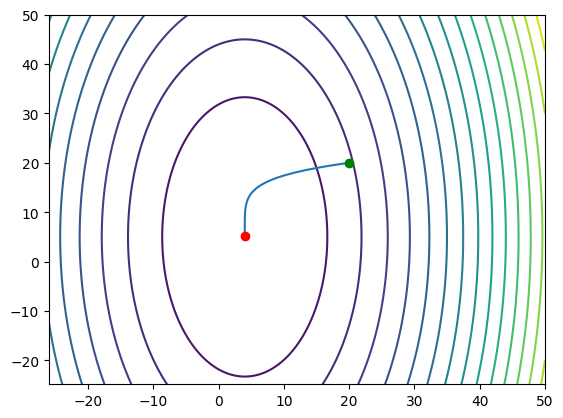


Const rate: 0.01 | Start x: [20. 20.] Epsilon: 0.001
Count steps: 808
Final point: [3.89445420e-16 7.87618854e-01]


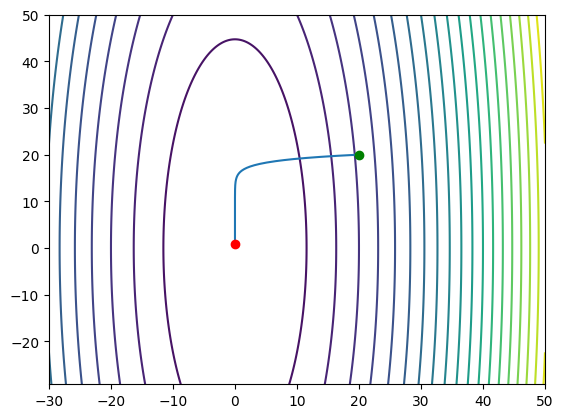


Const rate: 0.01 | Start x: [20. 20.] Epsilon: 0.001
Count steps: 141
Final point: [-2.17974508  1.01391333]


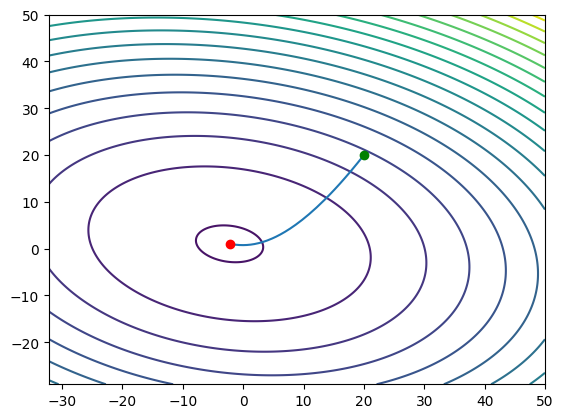

In [257]:
def test_convergence_const_lr(func):
    lr = 0.01
    eps = 0.001
    x = np.array((20., 20.))

    print('Const rate: ' + str(lr) + ' | Start x: ' + str(x) + ' Epsilon: ' + str(eps))
    points = grad_desc(func, lambda *_: lr, x, eps)
    print('Count steps: ' + str(len(points)))
    print('Final point: ' + str(points[-1]))
    visualise_points(func, points)
    print()


for func in functions:
    test_convergence_const_lr(func)

### 4(b) Сравнение количества

Const rate: 0.01 | Start x: [20. 20.] Epsilon: 0.01
Count steps with const rate: 171
Final point with const rate: [4.00000027 5.48364213]


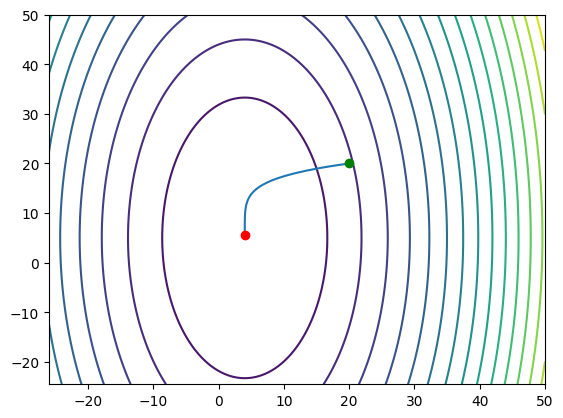

Start x: [20. 20.] Epsilon: 0.01 | Delta: 0.001
Count steps with dichotomy: 7
Final point with dichotomy: [4.00330326 5.00183366]


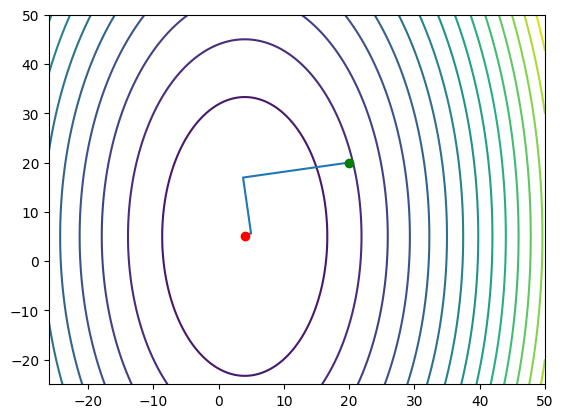


Const rate: 0.01 | Start x: [20. 20.] Epsilon: 0.01
Count steps with const rate: 521
Final point with const rate: [2.12719599e-13 2.48820395e+00]


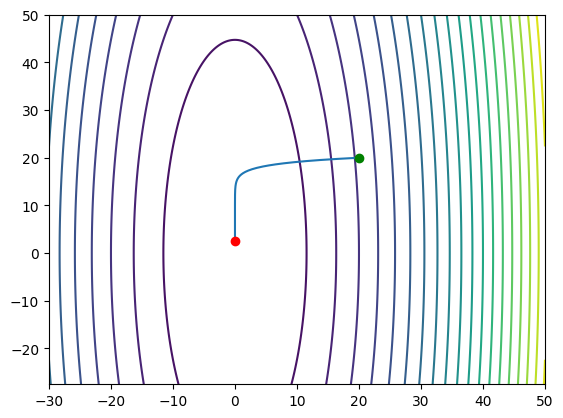

Start x: [20. 20.] Epsilon: 0.01 | Delta: 0.001
Count steps with dichotomy: 6
Final point with dichotomy: [-0.00020849  0.05099657]


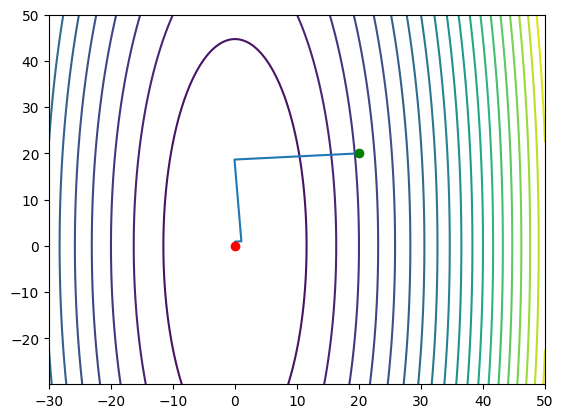


Const rate: 0.01 | Start x: [20. 20.] Epsilon: 0.01
Count steps with const rate: 111
Final point with const rate: [-2.01015185  0.97563112]


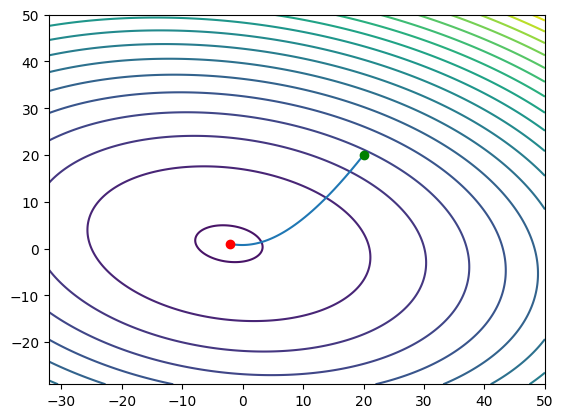

Start x: [20. 20.] Epsilon: 0.01 | Delta: 0.001
Count steps with dichotomy: 7
Final point with dichotomy: [-2.25514079  1.03542951]


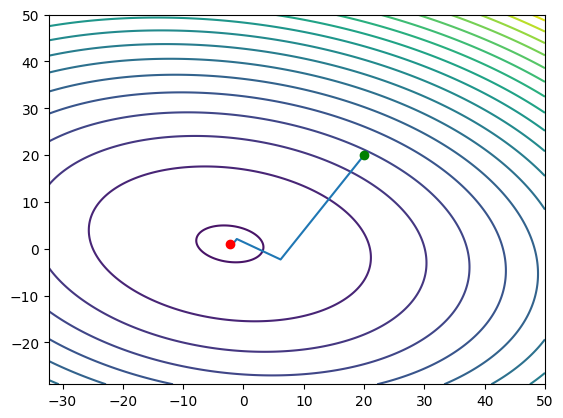

In [258]:
def compare_count_calculations(func):
    lr = 0.01
    eps = 0.01
    delt = 0.001
    x = np.array((20., 20.))

    print('Const rate: ' + str(lr) + ' | Start x: ' + str(x) + ' Epsilon: ' + str(eps))
    points_const_lr = grad_desc(func, lambda *_: lr, x, eps)
    print('Count steps with const rate: ' + str(len(points_const_lr)))
    print('Final point with const rate: ' + str(points_const_lr[-1]))
    visualise_points(func, points_const_lr)

    print('Start x: ' + str(x) + ' Epsilon: ' + str(eps) + ' | Delta: ' + str(delt))
    points_dichotomy = grad_desc(func, lr_wrapper(eps, delt), x, eps)
    print('Count steps with dichotomy: ' + str(len(points_dichotomy)))
    print('Final point with dichotomy: ' + str(points_dichotomy[-1]))
    visualise_points(func, points_dichotomy)
    print()


for func in functions:
    compare_count_calculations(func)

### 4(c) Тест на разные начальные точки

Const rate: 0.01 | Start x: [20. 20.] Epsilon: 0.01
Count steps with const rate: 171
Final point with const rate: [4.00000027 5.48364213]


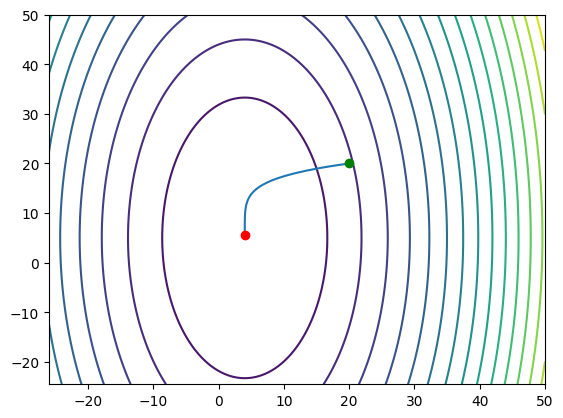

Start x: [20. 20.] Epsilon: 0.01 | Delta: 0.001
Count steps with dichotomy: 7
Final point with dichotomy: [4.00330326 5.00183366]


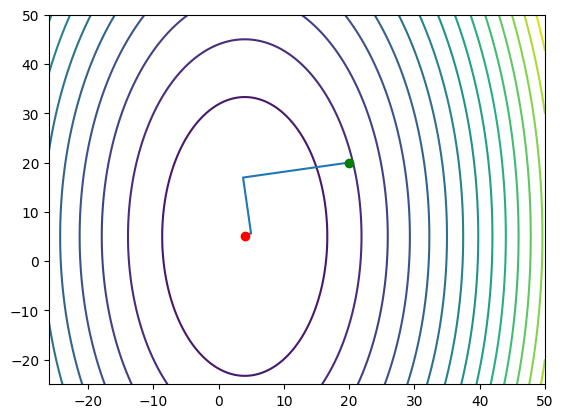


Const rate: 0.01 | Start x: [ -5. -10.] Epsilon: 0.01
Count steps with const rate: 171
Final point with const rate: [3.99999985 4.51635787]


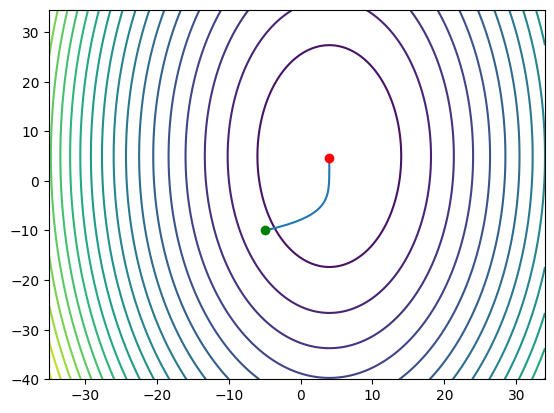

Start x: [ -5. -10.] Epsilon: 0.01 | Delta: 0.001
Count steps with dichotomy: 10
Final point with dichotomy: [4.00187535 4.9708321 ]


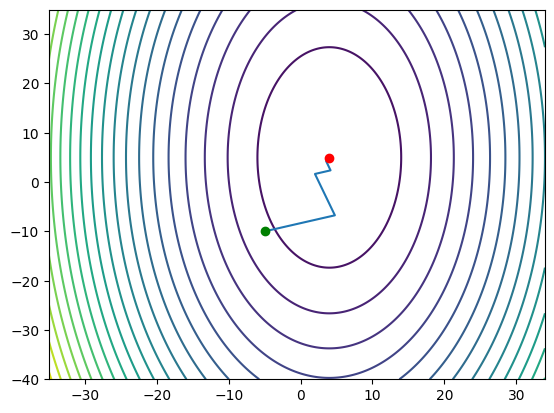


Const rate: 0.01 | Start x: [-8. 10.] Epsilon: 0.01
Count steps with const rate: 116
Final point with const rate: [3.99993437 5.48974353]


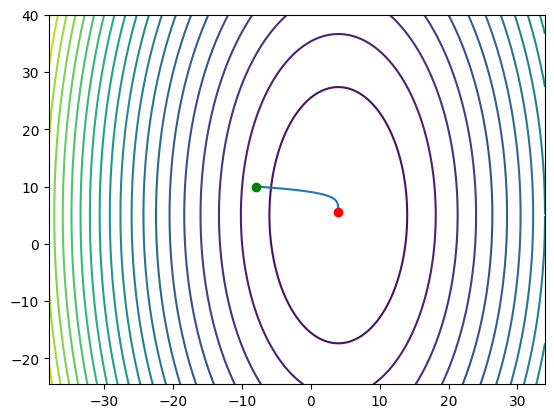

Start x: [-8. 10.] Epsilon: 0.01 | Delta: 0.001
Count steps with dichotomy: 6
Final point with dichotomy: [4.00060495 5.01036723]


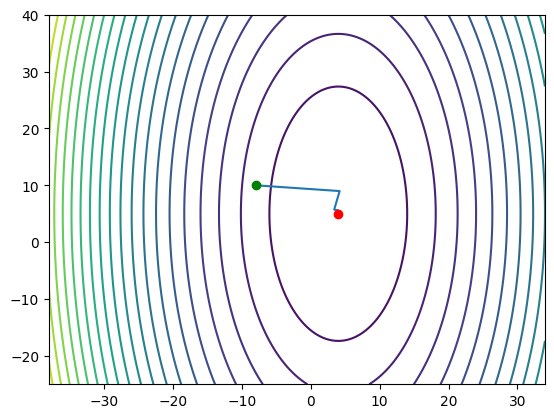


Const rate: 0.01 | Start x: [20. 20.] Epsilon: 0.01
Count steps with const rate: 521
Final point with const rate: [2.12719599e-13 2.48820395e+00]


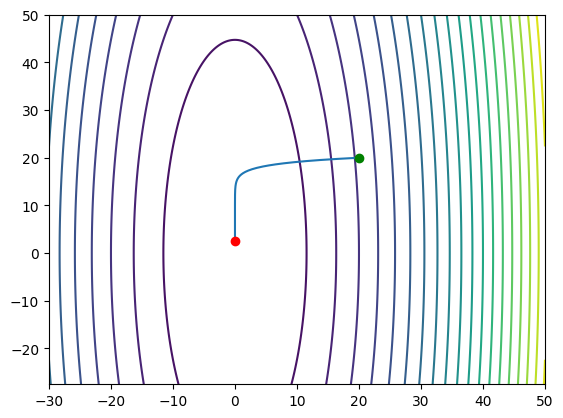

Start x: [20. 20.] Epsilon: 0.01 | Delta: 0.001
Count steps with dichotomy: 6
Final point with dichotomy: [-0.00020849  0.05099657]


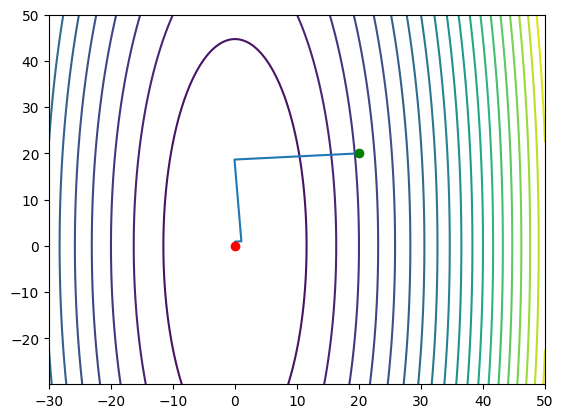


Const rate: 0.01 | Start x: [ -5. -10.] Epsilon: 0.01
Count steps with const rate: 348
Final point with const rate: [-2.36774822e-09 -2.48880249e+00]


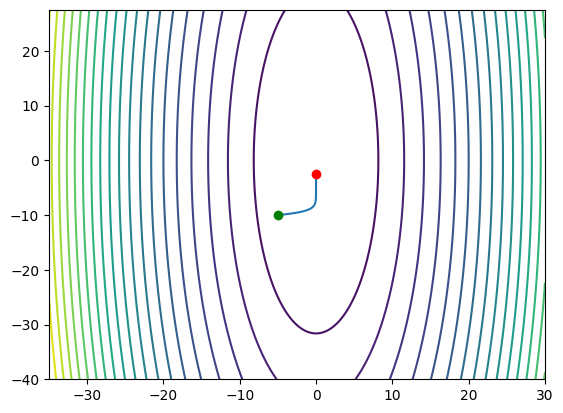

Start x: [ -5. -10.] Epsilon: 0.01 | Delta: 0.001
Count steps with dichotomy: 5
Final point with dichotomy: [-0.01143159 -0.02415556]


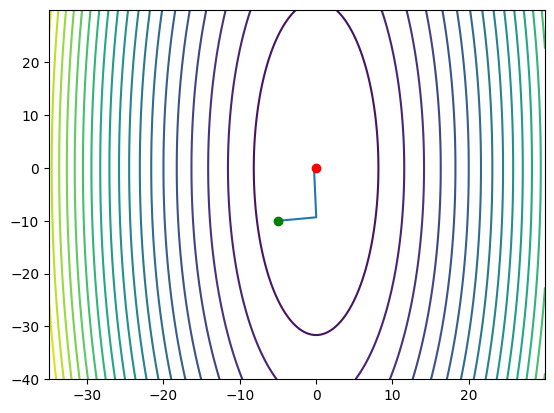


Const rate: 0.01 | Start x: [-8. 10.] Epsilon: 0.01
Count steps with const rate: 348
Final point with const rate: [-3.78839538e-09  2.48880249e+00]


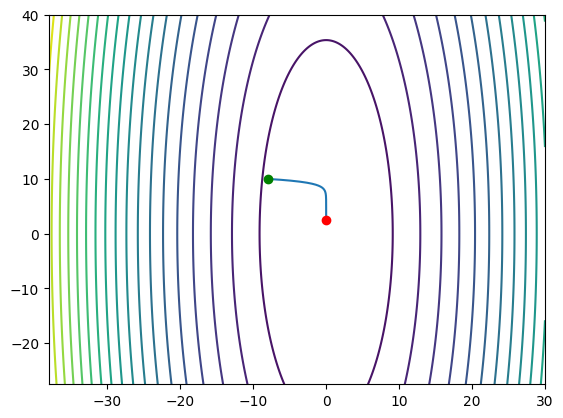

Start x: [-8. 10.] Epsilon: 0.01 | Delta: 0.001
Count steps with dichotomy: 6
Final point with dichotomy: [8.23210291e-05 2.44786013e-02]


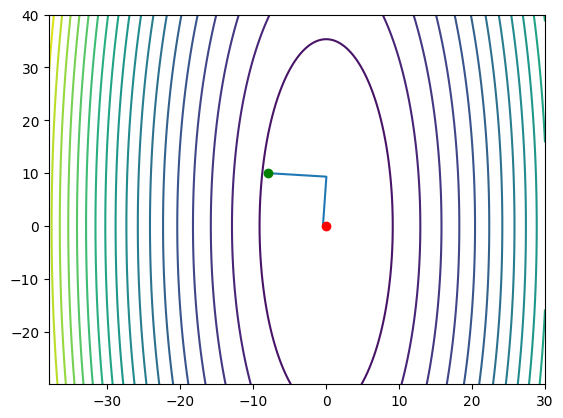


Const rate: 0.01 | Start x: [20. 20.] Epsilon: 0.01
Count steps with const rate: 111
Final point with const rate: [-2.01015185  0.97563112]


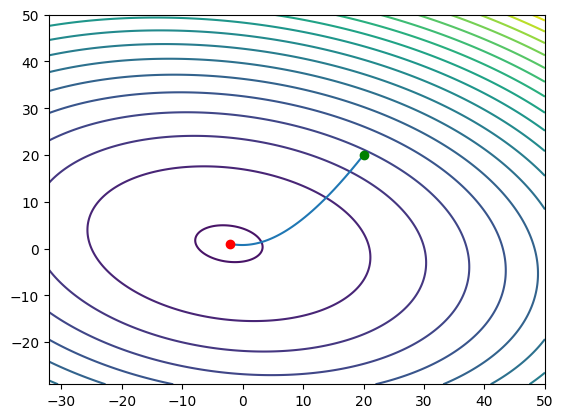

Start x: [20. 20.] Epsilon: 0.01 | Delta: 0.001
Count steps with dichotomy: 7
Final point with dichotomy: [-2.25514079  1.03542951]


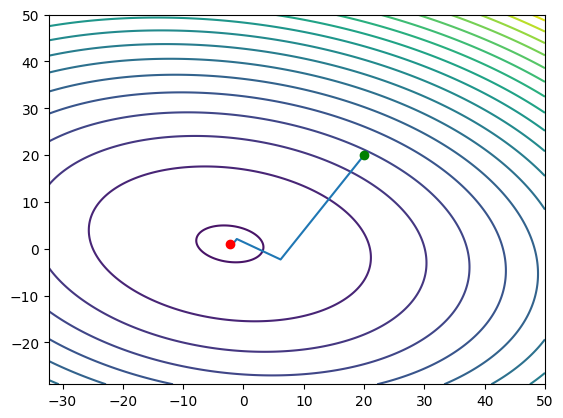


Const rate: 0.01 | Start x: [ -5. -10.] Epsilon: 0.01
Count steps with const rate: 55
Final point with const rate: [-2.29966726  0.92943345]


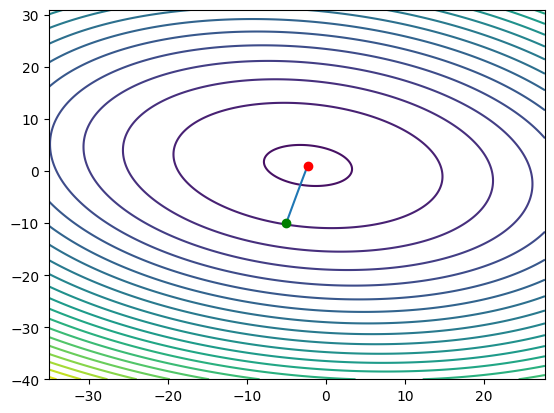

Start x: [ -5. -10.] Epsilon: 0.01 | Delta: 0.001
Count steps with dichotomy: 4
Final point with dichotomy: [-2.26591195  1.03715781]


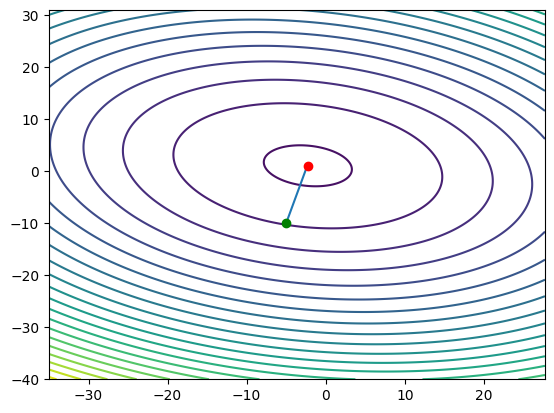


Const rate: 0.01 | Start x: [-8. 10.] Epsilon: 0.01
Count steps with const rate: 90
Final point with const rate: [-2.50209366  1.09349065]


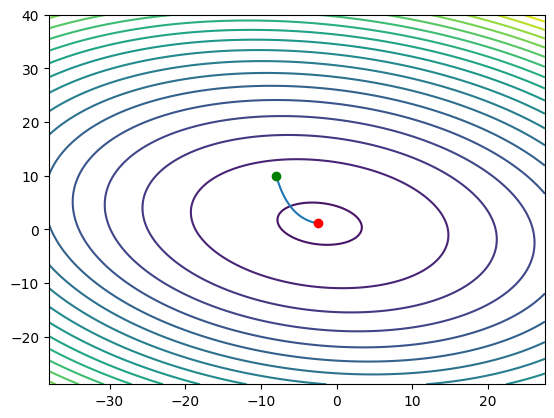

Start x: [-8. 10.] Epsilon: 0.01 | Delta: 0.001
Count steps with dichotomy: 7
Final point with dichotomy: [-2.26130721  1.0383482 ]


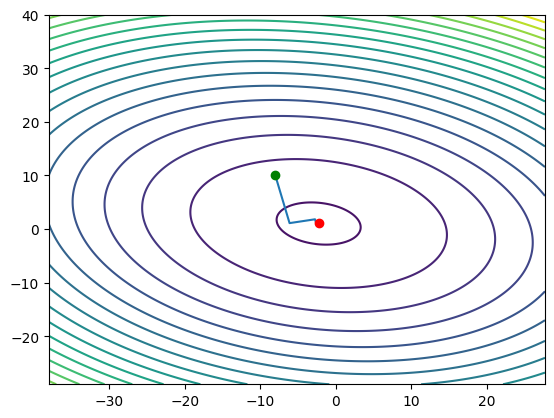

In [259]:
def test_different_start_points(func):
    start_x = [np.array(x) for x in [(20., 20.), (-5., -10.), (-8., 10.)]]
    for x in start_x:
        lr = 0.01
        eps = 0.01
        delt = 0.001

        print('Const rate: ' + str(lr) + ' | Start x: ' + str(x) + ' Epsilon: ' + str(eps))
        points_const_lr = grad_desc(func, lambda *_: lr, x, eps)
        print('Count steps with const rate: ' + str(len(points_const_lr)))
        print('Final point with const rate: ' + str(points_const_lr[-1]))
        visualise_points(func, points_const_lr)

        print('Start x: ' + str(x) + ' Epsilon: ' + str(eps) + ' | Delta: ' + str(delt))
        points_dichotomy = grad_desc(func, lr_wrapper(eps, delt), x, eps)
        print('Count steps with dichotomy: ' + str(len(points_dichotomy)))
        print('Final point with dichotomy: ' + str(points_dichotomy[-1]))
        visualise_points(func, points_dichotomy)
        print()


for func in functions:
    test_different_start_points(func)

### 4(d) Исследование влияния нормализации

In [260]:
def test_scaling(func):
    func_scale = Function(lambda x: func.value(np.array([x[0], 1.5 ** x[1]])))
    eps = 0.01
    delt = 0.001
    x = np.array((20., 20.))

    print('Epsilon: ' + str(eps) + ' | Delta: ' + str(delt))
    res_func = grad_desc(func, lr_wrapper(eps, delt), x, eps, need_points=False)
    print('Count steps of usual function: ' + str(res_func[1]) + ' value in point: ' + str(func.value(res_func[0])))
    res_scaling_func = grad_desc(func_scale, lr_wrapper(eps, delt), x, eps, need_points=False)
    print('Count steps of scaling function: ' + str(res_scaling_func[1]) + ' value in point: ' + str(
        func_scale.value(res_scaling_func[0])))
    print()


for func in [GeneratedFunctionCalculator(func_generator(2, k)) for k in range(10000, 10003)]:
    test_scaling(func)

Epsilon: 0.01 | Delta: 0.001
Count steps of usual function: 73 value in point: 502.33069643733324
Count steps of scaling function: 13 value in point: 3.719578337674683e-05

Epsilon: 0.01 | Delta: 0.001
Count steps of usual function: 9 value in point: 481.3521206974692
Count steps of scaling function: 12 value in point: 8.509610192319542e-05

Epsilon: 0.01 | Delta: 0.001
Count steps of usual function: 15 value in point: 441.30067196205346
Count steps of scaling function: 5 value in point: 3.40743170961706e-06



### 6 Исследование зависимости числа итераций от размерности пространства и числа обусловленности функции

15.1699


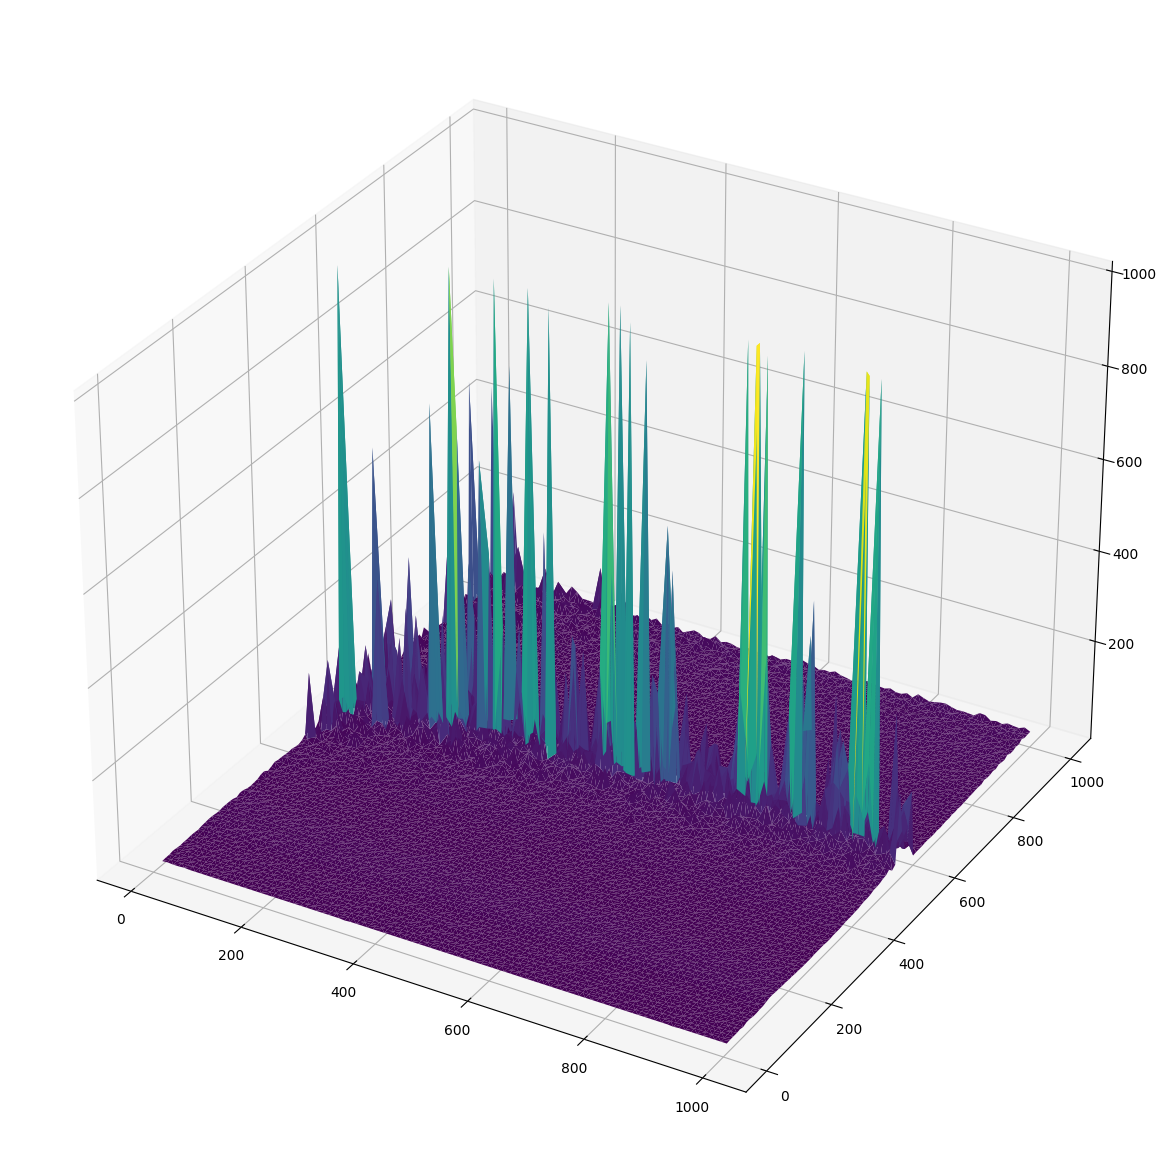

In [267]:
from_nk_to_num_of_steps = [[]]
x = []
y = []
z = []
cnst = 10
middle = 0
num_of_steps = 0
for n in range(2, 1001):
    for k in range(1, 1001):
        if (k % cnst == 0 and n % cnst == 0):
            x.append(n)
            y.append(k)
            z.append(grad_desc(
                func=GeneratedFunctionCalculator(func_generator(n, k)),
                lr=lr_wrapper(0.01, 0.001),
                x=np.array([20., 20.]), eps=0.1, need_points=False)[1])
            middle += z[len(z) - 1]
            num_of_steps += 1

print(middle / num_of_steps)
x = np.asarray(x)
y = np.asarray(y)
z = np.asarray(z)
ax = plt.axes(projection='3d')
ax.grid()
ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none')
# plt.figure().set_size_inches()
ax.figure.set_size_inches(15, 15)
plt.show()